In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import mahotas
import cv2 as cv
import pickle as pck

from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV

In [2]:
path_data = 'data/'
path_train = 'imagenes_color/train/'
path_test = 'imagenes_color/test/'
path_validar = 'imagenes_color/validar/'
path_features = 'features/'
path_training = 'training/'

In [3]:
def obtener_archivo(path_archivo):
    archivo = ''
    with (open(path_archivo, 'rb')) as pc_file:
        try:
            archivo = pck.load(pc_file)
        except EOFError as e:
            print(e)
            
    return archivo

### Cargamos las features guardadas

In [4]:
X_train = obtener_archivo(path_features + 'features-train.pck')
y_train = obtener_archivo(path_features + 'label-train.pck')
X_test = obtener_archivo(path_features + 'features-test.pck')
y_test = obtener_archivo(path_features + 'label-test.pck')

In [5]:
print('Features-train {}'.format(np.array(X_train).shape))
print('Labels-train {}'.format(np.array(y_train).shape))
print('Features-test {}'.format(np.array(X_test).shape))
print('Labels-test {}'.format(np.array(y_test).shape))

Features-train (1198, 532)
Labels-train (1198,)
Features-test (238, 532)
Labels-test (238,)


In [6]:
targetNames = np.unique(y_train)

scaler = MinMaxScaler(feature_range=(0, 1))
le = LabelEncoder()

X_train_n = scaler.fit_transform(X_train)
y_train_n = le.fit_transform(y_train)
X_test_n = scaler.fit_transform(X_test)
y_test_n = le.fit_transform(y_test)

In [7]:
def evaluar_modelos_multi(X, y, cv):
    valores_modelos = {}
    
    parametros = {'SVC' : {'estimator__kernel' :['poly', 'rbf', 'sigmoid'], 
                          'estimator__C' : [1, 10, 100]},
                  'LGR' : {'estimator__solver' : ['newton-cg', 'liblinear'], 
                          'estimator__C' : [1, 10, 100]},
                  'RTF' : {'estimator__n_estimators' : [100, 200, 300], 
                         'estimator__max_depth' : [2, 4, 8, 10],
                         'estimator__random_state' :[2, 4, 8, 10]},
                  'CART': {'estimator__max_depth': [1, 3, 5, 7], 
                           'estimator__max_features': [10, 20, 30, 40, 50]},
                  'NBG' : {}
                 }
    
    
    modelos = {'SVC' : OneVsRestClassifier(SVC(gamma = 'scale')),
               'LGR' : OneVsRestClassifier(LogisticRegression(max_iter = 300)),
               'RTF' : OneVsRestClassifier(RandomForestClassifier()),
               'CART': OneVsRestClassifier(DecisionTreeClassifier(random_state = 9)),
               'NBG' : OneVsRestClassifier(GaussianNB())
              }    
    
    for m in modelos:
        clf = GridSearchCV(modelos[m], parametros[m], cv = cv, iid = False, n_jobs = -1)
        clf.fit(X, y)
        valores_modelos[m] = [clf.best_score_, clf.best_params_, clf.refit_time_]       
   
    return valores_modelos

In [8]:
evaluacion = evaluar_modelos_multi(X_train_n, y_train_n, 10)

In [9]:
evaluacion

{'SVC': [0.8697969187675071,
  {'estimator__C': 10, 'estimator__kernel': 'rbf'},
  0.425983190536499],
 'LGR': [0.852296918767507,
  {'estimator__C': 10, 'estimator__solver': 'liblinear'},
  0.046088218688964844],
 'RTF': [0.8496218487394958,
  {'estimator__max_depth': 10,
   'estimator__n_estimators': 100,
   'estimator__random_state': 2},
  0.3533158302307129],
 'CART': [0.7904201680672269,
  {'estimator__max_depth': 7, 'estimator__max_features': 50},
  0.012776613235473633],
 'NBG': [0.7412184873949579, {}, 0.008742094039916992]}

## Nueva comprobación sin GridSearch
Al probar predicciones con los modelos anteriores no obtenía buenos resultados

In [10]:
modelos = []
modelos.append(('LR', LogisticRegression(random_state = 9)))
modelos.append(('LDA', LinearDiscriminantAnalysis()))
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier(random_state = 9)))
modelos.append(('RF', RandomForestClassifier(n_estimators = 200, random_state = 20)))
modelos.append(('NB', GaussianNB()))
modelos.append(('SVM', SVC(random_state = 9)))


results = []
names = []
scoring = "accuracy"


In [11]:
%%time
import warnings
warnings.filterwarnings('ignore')

# Utilizando kfold
for nombre, modelo in modelos:
    kfold = KFold(n_splits = 10, random_state = 7)
    cv_results = cross_val_score(modelo, 
                                 X_train_n, 
                                 y_train_n, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(nombre)
    print('{}: {} ({})'.format(nombre, cv_results.mean(), cv_results.std()))



LR: 0.7720728291316526 (0.09874032421131716)
LDA: 0.7321988795518207 (0.08085921795558383)
KNN: 0.7013865546218486 (0.1192955927842099)
CART: 0.7269747899159664 (0.07369375258740231)
RF: 0.8062394957983192 (0.10660085373210859)
NB: 0.7290336134453781 (0.18729139520245675)
SVM: 0.0 (0.0)
CPU times: user 34.2 s, sys: 424 ms, total: 34.6 s
Wall time: 16.8 s


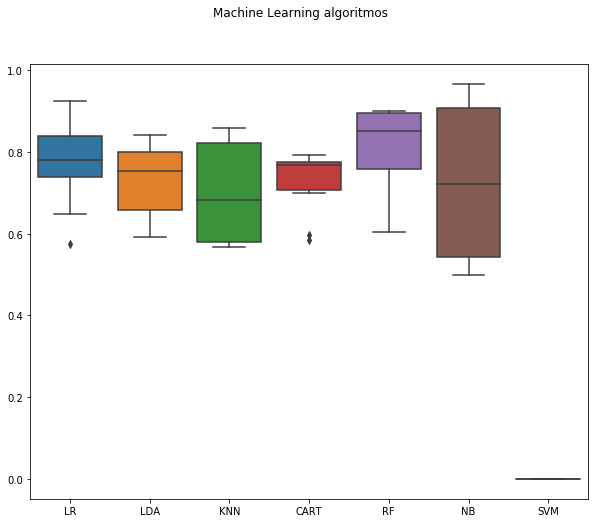

In [66]:
fig = plt.figure(figsize = (10,8))

fig.suptitle('Machine Learning algoritmos')
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set_xticklabels(names)
plt.show()

In [16]:
def hu_moments(imagen):
    imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    feature = cv.HuMoments(cv.moments(imagen)).flatten()
    return feature

In [17]:
def textura(imagen):
    gris = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gris).mean(axis=0)
    return haralick

In [18]:
def histograma_color(imagen, mask = None):
    imagen = cv.cvtColor(imagen, cv.COLOR_BGR2HSV)
    hist  = cv.calcHist([imagen], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv.normalize(hist, hist)
    return hist.flatten()

In [19]:
tamano = (256, 256)
estilos = ['abstract-art', 'realism']

### Se prueba con Random Forest

In [37]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 20, max_depth = 10)
entrenamiento = clf.fit(X_train_n, y_train_n)

In [38]:
prediccion = entrenamiento.predict(X_test_n)
confusion = confusion_matrix(y_test_n,prediccion)
confusion

array([[105,  13],
       [ 10, 110]])

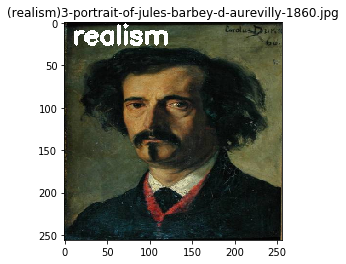

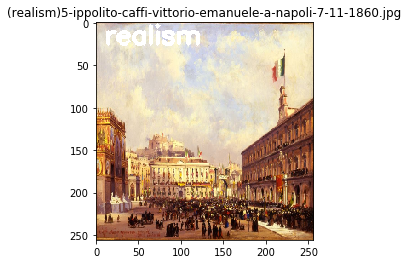

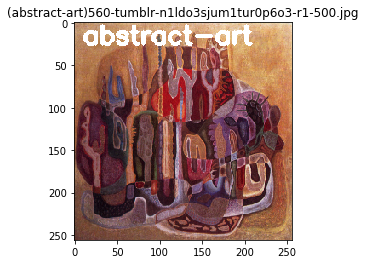

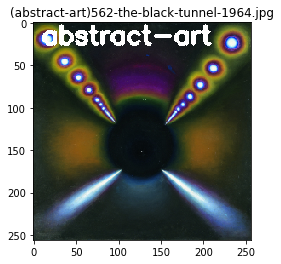

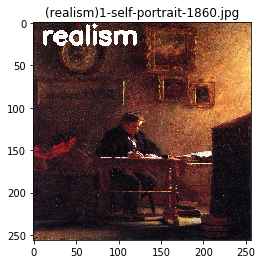

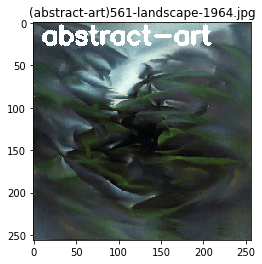

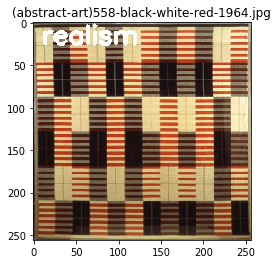

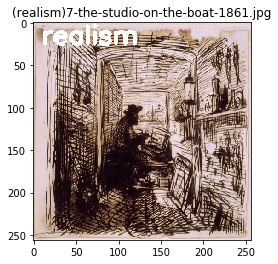

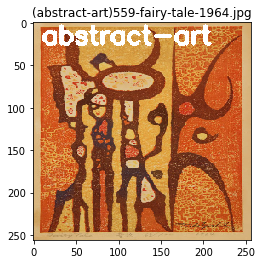

In [40]:
for file in glob.glob(path_validar + "/*.jpg"):
    image = cv.imread(file)
    image = cv.resize(image, tamano)

    hu = hu_moments(image)
    haralick_im   = textura(image)
    histograma_im  = histograma_color(image)

    features_imagen = np.hstack([histograma_im, haralick_im, hu])

    prediction = entrenamiento.predict(features_imagen.reshape(1,-1))[0]
    #print(prediction)
    cv.putText(image, estilos[prediction], (10, 25), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 4)

    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(file.split('/')[-1])
    plt.show()

In [57]:
def dibuja_matriz(matrix, title, columnas, formato = 0):
    '''
    Para dibujar la matriz de confusión
    matrix : matrix de confusión
    title: título para el gráfico
    columnas: nombre para las columnas (lista)
    formato: el formato para mostrar los datos
        1 : .2f
        2 : .2%
        3 : d
    '''
    if formato == 1:
        fmt = '.2f'
        annot = True
    elif formato == 2:
        fmt = '.2%'
        annot = True
    elif format == 3:
        fmt = 'd'
        annot = True
    else:
        fmt = ''
        annot = False
    
    
    df = pd.DataFrame(matrix, 
                         index = [i for i in columnas],
                         columns = [i for i in columnas])

    plt.figure(figsize = (10,8))
    sns.heatmap(df ,linewidths = .1, cmap = 'YlGnBu', fmt = fmt, annot = annot)
    plt.title(title)
    plt.yticks(rotation = 0);

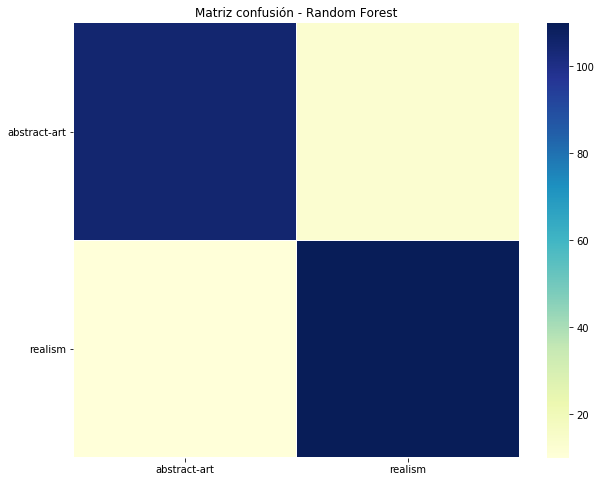

In [60]:
dibuja_matriz(confusion, 'Matriz confusión - Random Forest', estilos)

In [71]:
def guardar_archivo(contenido, path_archivo):
    archivo = ''
    with (open(path_archivo, 'wb')) as pc_file:
        try:
            pck.dump(contenido, pc_file)
        except EOFError as e:
            print(e)
            
    return True

In [72]:
guardar_archivo(entrenamiento, 'training/rdf-100-20-10.ckpt')

True